## Open AI gym - MountainCar

### Rainbow

Lihtne DQN algoritm ei pruugi alati etteantud probleemi suuta lahendada. Põhjuseid selleks on mitmeid:

- agent ei pruugi avastada olulisi keskkonna piirkondi (*exploration vs exploitation*);
- agendi õpieesmärgid on seatud agendi enda poolt ja seega on nad alati kättesaamatud (põgenevad eest ära);
- DQN algoritm ennustab tagasiside keskväärtust, kuigi tõeline jaotus võib olla mitmetahulisem;
- DQN ei oska õppides priotiseerida varasemaid kogemusi vastavalt nende olulisusele;
- DQN ei oska eristada vahetu tagasiside väärtust ja tuleviku tagasiside lisandväärtust;
- DQN vaatab ainult ühe sammu ette, mistõttu on tal keeruline õppida pikemaid rajasõltuvusi.

DQN puuduste nimekiri võib olla veelgi pikem, ent antud probleemid on võtnud kokku *Rainbow* algoritm ([Hessel, M., Modayil, J., Van Hasselt, H., Schaul, T., Ostrovski, G., Dabney, W., ... & Silver, D. (2018, April). Rainbow: Combining improvements in deep reinforcement learning](https://arxiv.org/abs/1710.02298)), mis koondab endas järgnevaid arendusi:

- Noisy networks: [Fortunato, M., Azar, M. G., Piot, B., Menick, J., Osband, I., Graves, A., ... & Blundell, C. (2017). Noisy networks for exploration](https://arxiv.org/abs/1706.10295);
- Dueling DQN: [Wang, Z., Schaul, T., Hessel, M., Van Hasselt, H., Lanctot, M., & De Freitas, N. (2015). Dueling network architectures for deep reinforcement learning](https://arxiv.org/abs/1511.06581);
- Distributional RL: [Bellemare, M. G., Dabney, W., & Munos, R. (2017, August). A distributional perspective on reinforcement learning](https://arxiv.org/abs/1707.06887);
- PER: [Schaul, T., Quan, J., Antonoglou, I., & Silver, D. (2015). Prioritized experience replay](https://arxiv.org/abs/1511.05952);
- DDQN: [Van Hasselt, H., Guez, A., & Silver, D. (2016, March). Deep reinforcement learning with double q-learning](https://arxiv.org/abs/1509.06461);
- A3C: [Mnih, V., Badia, A. P., Mirza, M., Graves, A., Lillicrap, T., Harley, T., ... & Kavukcuoglu, K. (2016, June). Asynchronous methods for deep reinforcement learning](https://arxiv.org/abs/1602.01783).

In [1]:
#!pip3 install gym tensorflow numpy matplotlib

In [2]:
import gym

env = gym.make('MountainCar-v0')

### Noisy networks

In [3]:
import tensorflow as tf
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import init_ops

class NoisyNet(Layer):
    def __init__(self, **kwargs):
        super(NoisyNet, self).__init__(**kwargs)
        
    def build(self, input_shape):
        
        def make_noise(shape):
            kernel_noise_input = make_fg_noise(shape=[shape[0]])
            kernel_noise_output = make_fg_noise(shape=[shape[1]])
            kernel_noise = kernel_noise_input[:, tf.newaxis] * kernel_noise_output
            return kernel_noise
    
        def make_fg_noise(shape):
            noise = tf.random.normal(shape, dtype=self.dtype)
            trans_noise = tf.sign(noise) * tf.sqrt(tf.abs(noise))
            return tf.Variable(trans_noise, trainable=False, dtype=self.dtype)
        
        input_dim = input_shape[-1]
        kernel_shape = (1, input_dim)
        
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        scale_init = init_ops.Constant(value=1)#(.5 / np.sqrt(input_dim)))
        
        self.noise_scale = self.add_weight(
            name='noise_scale',
            shape=kernel_shape,
            initializer=scale_init,
            dtype=self.dtype,
            trainable=True
        )
        
        self.noise = make_noise(kernel_shape)
                
    def call(self, inputs):
        training = K.learning_phase()
        
        def add_noise():
            return inputs + self.noise_scale * self.noise
        
        output = tf_utils.smart_cond(training, add_noise, add_noise)#lambda: array_ops.identity(inputs))
        return output

### PER

In [4]:
class SumTree:
    data_pointer = 0
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
    
    def add(self, priority, data):
        tree_index = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data
        self.update(tree_index, priority)
        self.data_pointer += 1
        
        if self.data_pointer >= self.capacity:
            self.data_pointer = 0

    def update(self, tree_index, priority):
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
    
    def get_leaf(self, v):
        parent_index = 0
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else:
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                    
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index
            
        data_index = leaf_index - self.capacity + 1
        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    @property
    def total_priority(self):
        return self.tree[0]
    
class Memory:
    PER_e = 0.01 # min probability
    PER_a = 0.6  # 1-a = pr of selecting randomly (ignoring probability)
    PER_b = 0.4  # effecy of importance sampling (IS) weights on training
    PER_b_increment_per_sampling = 0.001
    absolute_error_upper = 1.

    def __init__(self, capacity):
        self.tree = SumTree(capacity)

    def store(self, experience):
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        if max_priority == 0:
            max_priority = self.absolute_error_upper
        
        self.tree.add(max_priority, experience)
        
    def sample(self, n):
        memory_b = []
        
        b_idx, b_ISWeights = np.empty((n,), dtype=np.int32), np.empty(n, dtype=np.float32)
        priority_segment = self.tree.total_priority / n
        self.PER_b = np.min([1., self.PER_b + self.PER_b_increment_per_sampling])
        p_min = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_priority
        max_weight = (p_min * n) ** (-self.PER_b)
        
        for i in range(n):
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)
            index, priority, data = self.tree.get_leaf(value)
            sampling_probabilities = priority / self.tree.total_priority
            
            b_ISWeights[i] = np.power(n * sampling_probabilities, -self.PER_b) / max_weight
            b_idx[i]= index
            experience = data
            memory_b.append(experience)
            
        return (b_idx, memory_b, b_ISWeights)

    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)

### N-step Distributional Dueling DDQN

In [5]:
import numpy as np
import random
from collections import deque
tfk = tf.keras
tfk.backend.clear_session()

class AIAgent:
    """
    A simple neural network based AI agent.
    """
    def __init__(self, train, model_weights_dir=None, memory=Memory(2500)):
        self.train = train
        self.memory_counter = 0
        self.memory = memory
        self.training_losses = deque(maxlen=10000)
        self.previous_state = None
        
        self.num_actions = 3
        self.batch_size = 32
        
        # N-step Q-learning
        self.n_step_gamma = 0.9
        self.n_steps = 5
        self.previous_states = deque(maxlen=max(1, self.n_steps - 1))
        
        # Distributional RL
        self.gamma = 0.99
        self.num_atoms = 51
        self.v_max = 0.07 ** 2 + sum([0.07 ** 2 * self.n_step_gamma ** i for i in range(1, self.n_steps + 1)])
        self.v_min = 1e-6
        self.delta_z = (self.v_max - self.v_min) / float(self.num_atoms - 1)
        self.z = [self.v_min + i * self.delta_z for i in range(self.num_atoms)]
        
        self.model_weights_dir = model_weights_dir
        self.model = self.create_model()
        self.target_model = self.create_model() # Dueling DQL
        self.tau=0.001 # soft update constant
        
    def act(self, obs):
        """
        Outputs model actions given the state.
        """
        if self.memory_counter >= self.memory.tree.capacity or not self.train:
            obs = self.reshape_single_obs(obs)
            z = self.model.predict(obs)
            z_concat = np.vstack(z)
            q = np.sum(np.multiply(z_concat, np.array(self.z)), axis=1)
            optimal_action_idxs = np.argmax(q)
            return optimal_action_idxs.tolist()
        else:
            return np.random.choice(list(range(3)), 1)[0]
    
    def create_model(self):
        """
        Defines the AI model.
        """
        def ddqn_join(inputs):
            value = inputs[0]
            advantage = inputs[1]
            output = value + tf.subtract(advantage, tf.reduce_mean(advantage, axis=-1, keepdims=True))
            return output
        
        def noisy_net(inputs, name):
            x = tfk.layers.Dense(32,activation=None, name=name + '_fully_connected')(inputs)
            x = NoisyNet(name=name + '_noise')(x)
            x = tfk.layers.ReLU(name=name + '_activation')(x)
            return x
        
        state = tfk.layers.Input(shape=(2), name='state')
        x = noisy_net(state, 'state')
                
        # DDQN
        value = tfk.layers.Dense(1, activation=None, name='value')(x)
        advantage = tfk.layers.Dense(self.num_actions, activation=None, name='advantage')(x)
        ddqn = tfk.layers.Lambda(ddqn_join, name='ddqn')([value, advantage])
        
        distribution_list = []
        for i in range(self.num_actions): 
            distribution_list.append(tfk.layers.Dense(self.num_atoms, activation='softmax', name='action_'+str(i))(ddqn))
        
        model = tfk.Model(inputs=state, outputs=distribution_list, name='rainbow')
        model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(lr=1e-3))
        
        if self.model_weights_dir:
            try:
                model.load_weights(self.model_weights_dir)
                print('Pretrained weights initialized.')
            except:
                print('New weights initialized.')
            
        return model
        
    def save_memory(self, obs, reward, action, done):
        """
        Save episodes and Q values for training the model.
        """
        obs = self.reshape_single_obs(obs)
        
        if self.train and len(self.previous_states) == self.previous_states.maxlen and not done:
            
            n_step_reward = 0
            for i, sate in enumerate(self.previous_states):
                n_step_reward += sate['reward'] * self.gamma ** (i + 1)
            reward = n_step_reward + reward * self.n_step_gamma ** (len(self.previous_states) + 1)
            
            z_ = self.target_model.predict(obs)
            z = self.target_model.predict(obs)
            z_concat = np.vstack(z)
            q = np.sum(np.multiply(z_concat, np.array(self.z)), axis=1)
            new_action = np.argmax(q).tolist()
            prev_action = self.previous_states[0]['action']
            
            m_prob = [np.zeros((1, self.num_atoms)) for i in range(self.num_actions)]
            if done:
                Tz = min(self.v_max, max(self.v_min, reward))
                bj = (Tz - self.v_min) / self.delta_z 
                m_l, m_u = np.floor(bj), np.ceil(bj)
                m_prob[prev_action][0][int(m_l)] += (m_u - bj)
                m_prob[prev_action][0][int(m_u)] += (bj - m_l)
            else:
                for j in range(self.num_atoms):
                    Tz = min(self.v_max, max(self.v_min, reward + self.gamma * self.z[j]))
                    bj = (Tz - self.v_min) / self.delta_z 
                    m_l, m_u = np.floor(bj), np.ceil(bj)
                    m_prob[prev_action][0][int(m_l)] += z_[new_action][0][j] * (m_u - bj)
                    m_prob[prev_action][0][int(m_u)] += z_[new_action][0][j] * (bj - m_l)            
            
            self.memory.store((self.previous_states[0]['obs'], m_prob))
            self.memory_counter += 1
            
        if done:
            self.previous_states = deque(maxlen=max(1, self.n_steps - 1))
        else:
            self.previous_states.append({
                'obs': obs,
                'reward': reward,
                'action': action
            })
            
        # train model on batch if memory is populated
        if self.train and self.memory_counter >= self.memory.tree.capacity:
            self.train_model()
            
    def train_model(self):
        """
        Trains the model on minibatch.
        """
        # sample random episides from memory
        batch_size = self.batch_size
        b_idx, batch, b_ISWeights = self.memory.sample(batch_size)
                
        X = []
        y = []
        for row in batch:
            X.append(row[0])
            y.append(row[1])
        X = np.vstack(X)
        y = np.hstack(y)
        y = [y[i] for i in range(y.shape[0])]
        
        sample_weights = {}
        for i in range(self.num_actions):
            sample_weights['action_'+str(i)] = np.where(np.sum(y[i], axis=1) == 0, 0, b_ISWeights)
        
        train_loss = self.model.train_on_batch(X, y, sample_weight=sample_weights)
        pred = self.model.predict(X)
        loss = self.loss(y, pred)
        
        self.memory.batch_update(b_idx, loss)
        self.training_losses.append(train_loss)
        
        if self.model_weights_dir:
            self.model.save(self.model_weights_dir)
        
        agent.target_model.set_weights([x * self.tau + (1-self.tau) * y for x, y in 
                                        zip(self.model.weights, self.target_model.weights)])
            
    def reshape_single_obs(self,obs):
        """
        Reshapes a single observation to fit the model.
        """
        return obs.reshape(1,-1)
    
    def loss(self, y_true, y_pred):
        y_true = np.vstack(y_true).reshape((self.batch_size, self.num_actions, self.num_atoms), order='F')
        y_pred = np.vstack(y_pred).reshape((self.batch_size, self.num_actions, self.num_atoms), order='F')
        logloss = -np.sum(np.sum(y_true * np.log(y_pred), axis=-1), axis=-1)
        return logloss

In [6]:
agent = AIAgent(train=True, model_weights_dir='model_checkpoints/rainbow.h5')

for i in range(20):
    print('Episode', i + 1, 'Reward sum ...', end='\r')
    observation = env.reset()
    done = False
    rewards = []
    while not done:
        env.render()
        action = agent.act(observation)
        observation, reward, done, info = env.step(action)
        
        reward = abs(observation[1]) ** 2
        agent.save_memory(observation, reward, action, done)
        rewards.append(reward)
    print('Episode', i + 1, 'Reward sum', round(np.sum(rewards),4))
        
env.close()

New weights initialized.
New weights initialized.
Episode 1 Reward sum 0.0186
Episode 2 Reward sum 0.0129
Episode 3 Reward sum 0.002
Episode 4 Reward sum 0.0008
Episode 5 Reward sum 0.0058
Episode 6 Reward sum 0.0099
Episode 7 Reward sum 0.0067
Episode 8 Reward sum 0.0203
Episode 9 Reward sum 0.0125
Episode 10 Reward sum 0.0315
Episode 11 Reward sum 0.0111
Episode 12 Reward sum 0.0024
Episode 13 Reward sum 0.0122
Episode 14 Reward sum 0.0038
Episode 15 Reward sum 0.0019
Episode 16 Reward sum 0.003
Episode 17 Reward sum 0.0001
Episode 18 Reward sum 0.003
Episode 19 Reward sum 0.0033
Episode 20 Reward sum 0.0005


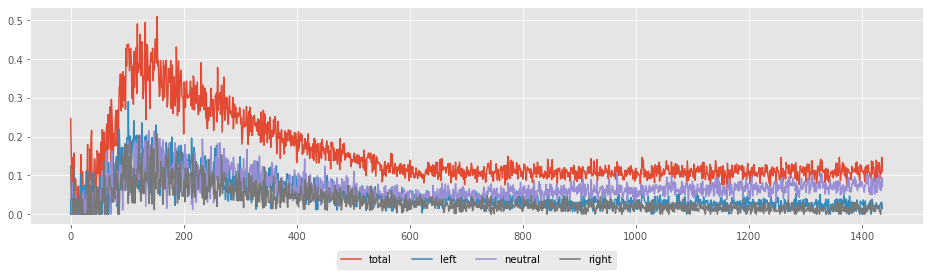

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'png'
plt.style.use('ggplot')

plt.figure(figsize=(16,4))
labels = ['total', 'left', 'neutral', 'right']
for i in range(4):
    plt.plot(np.vstack(agent.training_losses)[:,i], label=labels[i])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.show()